In [3]:
# GET PARAMETERS
import os 
import sys
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_and_visu_non_recurrent import evaluate_config,get_ds,train_the_config,get_ds_without_shuffling_on_train_set
from plotting.plotting import error_per_station_calendar_pattern,gain_between_models
from examples.train_model_on_k_fold_validation import load_configuration

In [19]:
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from trainer import Trainer
import torch 

trial_id1 ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
args1,_ = load_configuration(trial_id1,load_config=True)

fold_to_evaluate = [args1.K_fold-1]
modification = {'shuffle':False,
                'data_augmentation':False }

ds1,_,_,_,_ =  get_ds(args_init=args1,modification = modification,fold_to_evaluate=fold_to_evaluate)
model1 = load_model(ds1, args1)


>>>> Load best CONFIG
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776



Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


## Load Weights

In [1]:
# GET PARAMETERS
import os 
import sys
import torch 
# Get Parent folder : 
current_path = os.getcwd()
parent_dir = os.path.abspath(os.path.join(current_path, '..'))
if parent_dir not in sys.path:
    sys.path.insert(0, parent_dir)

from examples.train_model_on_k_fold_validation import train_model_on_k_fold_validation,load_configuration


save_folder = 'K_fold_validation/training_with_HP_tuning/re_validation'
trial_id = 'subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
name_trial = 'TEST'
epochs_validation = 1
args,folds = load_configuration(trial_id,True)

modification ={'keep_best_weights':True,
                'epochs':epochs_validation,
                'device':torch.device("cuda:1"),
                }


config_diffs = {name_trial:{}}

                
for add_name_id,config_diff in config_diffs.items():
    config_diff.update(modification)
    train_model_on_k_fold_validation(trial_id,load_config =True,
                                        save_folder=save_folder,
                                        modification=config_diff,
                                        add_name_id=add_name_id)

Training and Hyper-parameter tuning with Ray is not possible

>>>> Load best CONFIG

>>>> Load best CONFIG
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
2821 train samples had been added thank to Data Augmentation
calendar_dayofweek data augmented by dupplication but not modified
calendar_hour data augmented by dupplication but not modified
Train/Target size:  torch.Size([5642, 40, 7]) torch.Size([5642, 40, 1])
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 5642 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
1059 train samples had been added thank to Data Augmentation
ca

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 0 
 min\epoch : 1.15

Training Throughput:57.35 sequences per seconds
>>> Training complete in: 0:01:09.091050
>>> Training performance time: min 0.03172564506530762 avg 0.22598862648010254 seconds (+/- 0.18196111046939345)
>>> Loading performance time: min 0.0007426738739013672 avg 0.0013770081780173562 seconds (+/- 0.0014132606163266815)
>>> Forward performance time: 0.24829673333601518 seconds (+/- 0.1646518042911776)
>>> Backward performance time: 0.012813015417619185 seconds (+/- 0.016572269331347988)
>>> Plotting performance time: nan seconds (+/- nan)
>>> Saving performance time: 0.010913610458374023 seconds (+/- 0.0)
>>> PI-tracking performance time: nan seconds (+/- nan)
>>> Scheduler-update performance time: nan seconds (+/- nan)
>>> Peak Power during training: 105.137 W)
>>> Validation time: 0:00:10.546459
Proportion of time consumed for Loading: 0.3%
Proportion of time consumed for Forward: 50.8%
Proportion of time consumed for Backward: 2.6%
Proportion of time consu

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 0 
 min\epoch : 1.34

Training Throughput:48.88 sequences per seconds
>>> Training complete in: 0:01:20.482268
>>> Training performance time: min 0.01608753204345703 avg 0.33779382705688477 seconds (+/- 0.19206888142135242)
>>> Loading performance time: min 0.0006520748138427734 avg 0.0019103397022594106 seconds (+/- 0.00406715167636061)
>>> Forward performance time: 0.27638716408700653 seconds (+/- 0.1634526606923195)
>>> Backward performance time: 0.010834305575399689 seconds (+/- 0.012761391923976526)
>>> Plotting performance time: nan seconds (+/- nan)
>>> Saving performance time: 0.015797853469848633 seconds (+/- 0.0)
>>> PI-tracking performance time: nan seconds (+/- nan)
>>> Scheduler-update performance time: nan seconds (+/- nan)
>>> Peak Power during training: 107.684 W)
>>> Validation time: 0:00:07.785639
Proportion of time consumed for Loading: 0.4%
Proportion of time consumed for Forward: 57.6%
Proportion of time consumed for Backward: 2.3%
Proportion of time consume

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 0 
 min\epoch : 1.01

Training Throughput:48.29 sequences per seconds
>>> Training complete in: 0:01:00.520683
>>> Training performance time: min 0.015140295028686523 avg 0.3302370309829712 seconds (+/- 0.1836215487046998)
>>> Loading performance time: min 0.0007038116455078125 avg 0.0024675579814167764 seconds (+/- 0.005598221850612722)
>>> Forward performance time: 0.28307476910677826 seconds (+/- 0.15810058428480708)
>>> Backward performance time: 0.01375026052648371 seconds (+/- 0.01747003510135028)
>>> Plotting performance time: nan seconds (+/- nan)
>>> Saving performance time: 0.015009403228759766 seconds (+/- 0.0)
>>> PI-tracking performance time: nan seconds (+/- nan)
>>> Scheduler-update performance time: nan seconds (+/- nan)
>>> Peak Power during training: 117.0 W)
>>> Validation time: 0:00:02.532502
Proportion of time consumed for Loading: 0.7%
Proportion of time consumed for Forward: 81.2%
Proportion of time consumed for Backward: 3.9%
Proportion of time consumed f

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


epoch: 0 
 min\epoch : 1.09

Training Throughput:56.85 sequences per seconds
>>> Training complete in: 0:01:05.699678
>>> Training performance time: min 0.018933773040771484 avg 0.26168227195739746 seconds (+/- 0.18336415628275282)
>>> Loading performance time: min 0.0006849765777587891 avg 0.001999799500812184 seconds (+/- 0.003425927419659212)
>>> Forward performance time: 0.2452797225930474 seconds (+/- 0.15923517236452137)
>>> Backward performance time: 0.010394561019810762 seconds (+/- 0.011454824155598195)
>>> Plotting performance time: nan seconds (+/- nan)
>>> Saving performance time: 0.01617264747619629 seconds (+/- 0.0)
>>> PI-tracking performance time: nan seconds (+/- nan)
>>> Scheduler-update performance time: nan seconds (+/- nan)
>>> Peak Power during training: 106.544 W)
>>> Validation time: 0:00:00.981365
Proportion of time consumed for Loading: 0.7%
Proportion of time consumed for Forward: 83.5%
Proportion of time consumed for Backward: 3.5%
Proportion of time consume

/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:206: RuntimeWarning: Degrees of freedom <= 0 for slice
  ret = _var(a, axis=axis, dtype=dtype, out=out, ddof=ddof,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:163: RuntimeWarning: invalid value encountered in divide
  arrmean = um.true_divide(arrmean, div, out=arrmean,
/root/anaconda3/envs/pytorch-2.0.1/lib/python3.10/site-packages/numpy/core/_methods.py:198: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


## Load l'entrainement, et vérifie que les métriques sont cohérentes : 

In [6]:
from high_level_DL_method import load_model,load_optimizer_and_scheduler
from trainer import Trainer
import torch 

args1,_ = load_configuration(trial_id,load_config=True)
fold_to_evaluate = [args1.K_fold-1]
modification = {'shuffle':False,
                'data_augmentation':False }

ds1,_,_,_,_ =  get_ds(args_init=args1,modification = modification,fold_to_evaluate=fold_to_evaluate)
model1 = load_model(ds1, args1)
model_param1 = torch.load(f"save/{save_folder}/best_models/{trial_id}{name_trial}_F{args.K_fold}_fcomplete_dataset.pkl")
model1.load_state_dict(model_param1['state_dict'],strict=True)

optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model1,args1)
trainer1 = Trainer(ds1,model1,args1,optimizer,loss_function,scheduler = scheduler)

training_mode = 'test'
full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
Y_true= Y_true.detach().clone().reshape(-1)    
full_predict1= full_predict1.detach().clone().reshape(-1)    
error_pred1 = ((Y_true - full_predict1)**2).mean()

print(error_pred1)


>>>> Load best CONFIG
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values


Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Model size: 0.000GB
number of total parameters: 71713
number of trainable parameters: 71713


FileNotFoundError: [Errno 2] No such file or directory: 'save/K_fold_validation/training_with_HP_tuning/re_validation/best_models/subway_in_STGCN_MSELoss_2025_01_20_14_27_20569TEST_F6_fcomplete_dataset.pkl'

In [26]:
#weights_id = subway_in_STGCN_MSELoss_2025_01_20_14_40_26118_F6_fcomplete_dataset
weights_id = 'subway_in_STGCN_MSELoss_2025_01_17_18_31_60147_F6_fcomplete_dataset'
for weights_id in ['subway_in_STGCN_MSELoss_2025_01_17_18_31_60147_F6_fcomplete_dataset',
                   'subway_in_STGCN_MSELoss_2025_01_20_14_40_26118_F6_fcomplete_dataset',
                   'subway_in_STGCN_MSELoss_2025_01_17_15_14_85172_F6_fcomplete_dataset',
                   'subway_in_STGCN_MSELoss_2025_01_06_08_04_25065_F6_fcomplete_dataset']:
    
    model_param1 = torch.load(f"save/K_fold_validation/training_with_HP_tuning/best_models/{weights_id}.pkl")
    model1.load_state_dict(model_param1['state_dict'],strict=True)

    optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model1,args1)
    trainer1 = Trainer(ds1,model1,args1,optimizer,loss_function,scheduler = scheduler)

    training_mode = 'test'
    full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
    Y_true= Y_true.detach().clone().reshape(-1)    
    full_predict1= full_predict1.detach().clone().reshape(-1)    
    error_pred1 = ((Y_true - full_predict1)**2).mean()

    print(error_pred1)

tensor(1548.8955)
tensor(1552.6803)
tensor(2363.5447)
tensor(1831.7053)


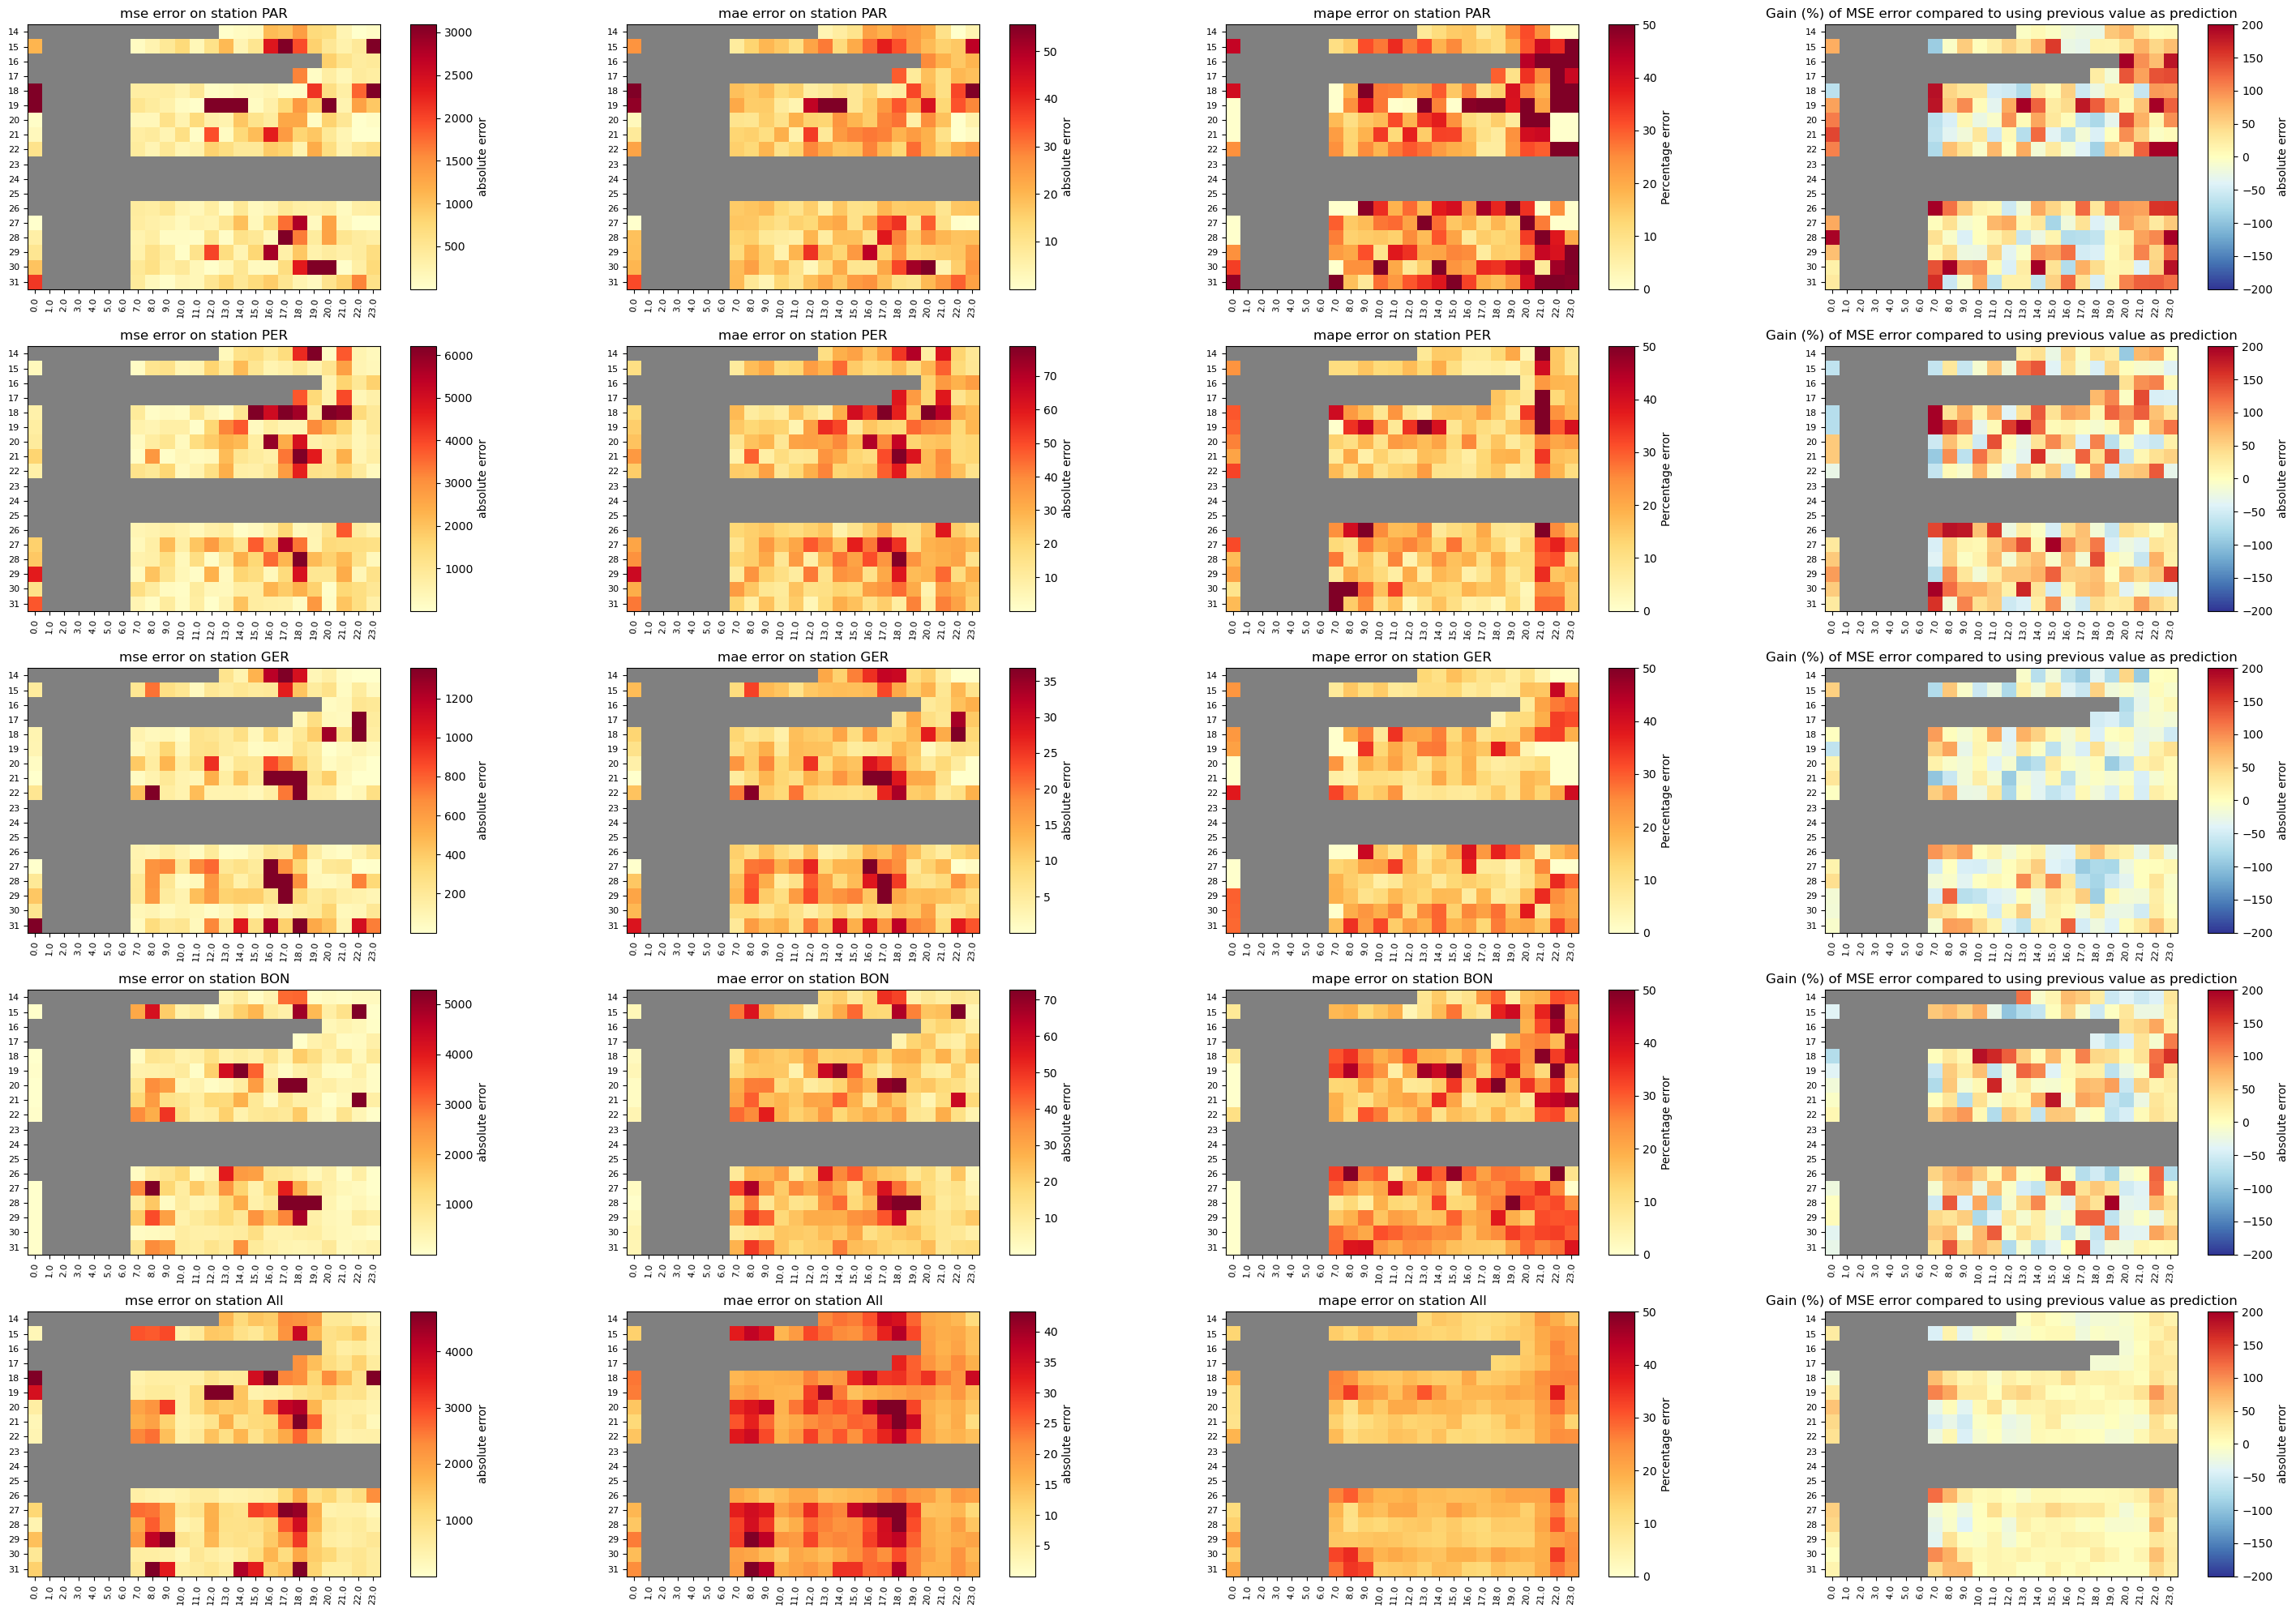

In [3]:
# Init
training_mode_to_visualise = ['test']
station = ['PAR','PER','GER','BON']
for training_mode in training_mode_to_visualise:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(station)),
                                                limit_percentage_error = limit_percentage_error,
                                                stations = station)


In [4]:
trial_id2 ='subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_05_38_87836' #Concate Early & Late

args2,_ = load_configuration(trial_id2,load_config=True)

fold_to_evaluate = [args2.K_fold-1]
modification = {'shuffle':False,
                'data_augmentation':False }

ds2,_,_,_,_ =  get_ds(args_init=args2,modification = modification,fold_to_evaluate=fold_to_evaluate)
model2 = load_model(ds2, args2)


>>>> Load best CONFIG
>>>>Model: STGCN; K_fold = 6; Loss function: MSE 
Invalid dates within this fold: 776

Init Dataset: 'torch.Size([7392, 40]) with 295680 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
Init U/Utarget size: torch.Size([4702, 40, 7])/torch.Size([4702, 40, 1]) Train/Valid/Test 2821 940 940

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
Invalid dates within this fold: 481

Init Dataset: 'torch.Size([4597, 40]) with 183880 Total nb of elements and 0 Nan values
vision_input_type POIs
vision_model_name VariableSelectionNetwork
Init U/Utarget size: torch.Size([2940, 40, 7])/torch.Size([2940, 40, 1]) Train/Valid/Test 1059 941 939

 ===== ERROR WITH prefetch_factor====  
ValueError: prefetch_factor option could only be specified in multiprocessing.let num_workers > 0 to enable multiprocessing
number of

## Load Weights

In [ ]:
weights_id = 'subway_in_subway_out_STGCN_VariableSelectionNetwork_MSELoss_2025_01_20_07_23_40226_F6_fcomplete_dataset'
model_param2 = torch.load(f"save/K_fold_validation/training_with_HP_tuning/best_models/{weights_id}.pkl")
model2.load_state_dict(model_param2['state_dict'],strict=True)

optimizer,scheduler,loss_function = load_optimizer_and_scheduler(model2,args2)
trainer2 = Trainer(ds2,model2,args2,optimizer,loss_function,scheduler = scheduler)

## Gain de Model2 par rapport à Model1

In [25]:
training_mode = 'test'
full_predict1,Y_true,_ = trainer1.testing(ds1.normalizer, training_mode =training_mode)
full_predict2,_,_ = trainer2.testing(ds2.normalizer, training_mode =training_mode)

Y_true= Y_true.detach().clone().reshape(-1)    
full_predict1= full_predict1.detach().clone().reshape(-1)    
full_predict2= full_predict2.detach().clone().reshape(-1)   

error_pred1 = ((Y_true - full_predict1)**2).mean()
error_pred2 = ((Y_true - full_predict2)**2).mean()

print(error_pred1,error_pred2)

tensor(1548.8955) tensor(1395.2932)


In [12]:
station = list(ds.spatial_unit) #['PAR','PER','GER','BON']
gain_between_models(trainer,trainer2,ds,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        figsize = (30,5*len(station)),
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station)

(<Figure size 3000x20000 with 246 Axes>,
 array([[<Axes: title={'center': 'mse error on station AMP'}>,
         <Axes: title={'center': 'mae error on station AMP'}>,
         <Axes: title={'center': 'mape error on station AMP'}>],
        [<Axes: title={'center': 'mse error on station BEL'}>,
         <Axes: title={'center': 'mae error on station BEL'}>,
         <Axes: title={'center': 'mape error on station BEL'}>],
        [<Axes: title={'center': 'mse error on station BRO'}>,
         <Axes: title={'center': 'mae error on station BRO'}>,
         <Axes: title={'center': 'mape error on station BRO'}>],
        [<Axes: title={'center': 'mse error on station COR'}>,
         <Axes: title={'center': 'mae error on station COR'}>,
         <Axes: title={'center': 'mape error on station COR'}>],
        [<Axes: title={'center': 'mse error on station CUI'}>,
         <Axes: title={'center': 'mae error on station CUI'}>,
         <Axes: title={'center': 'mape error on station CUI'}>],
    

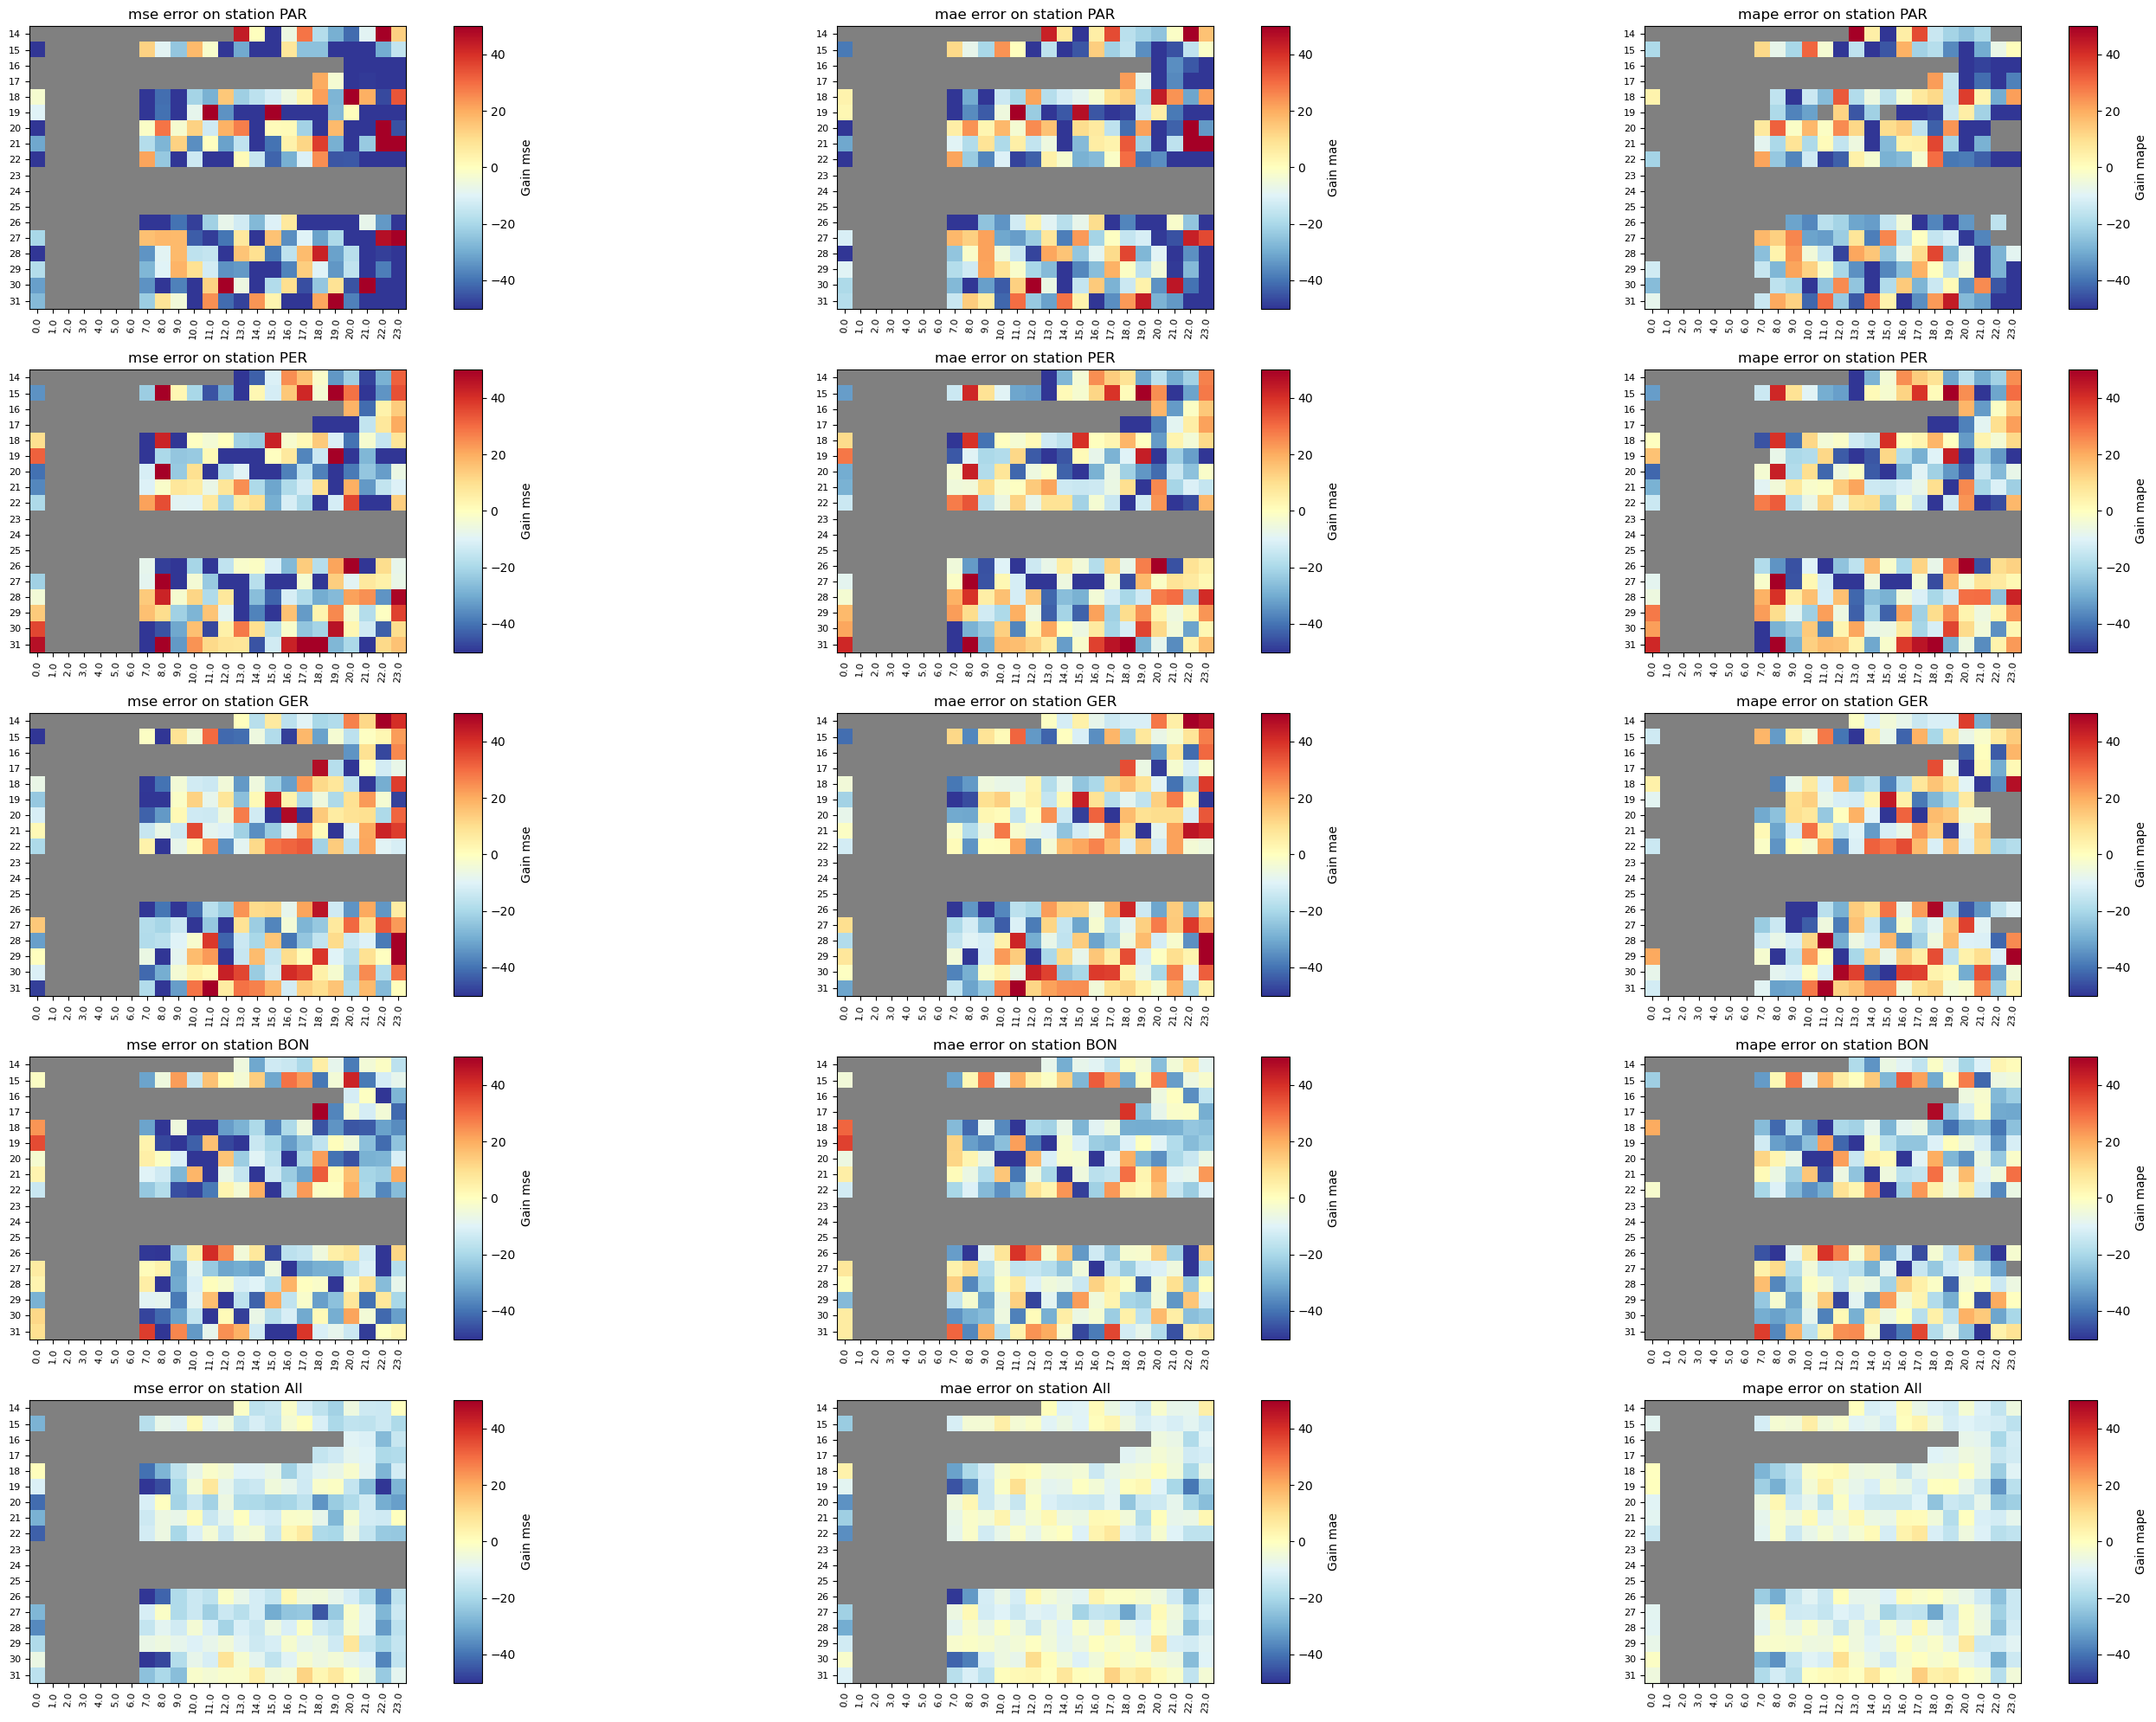

(<Figure size 3000x2000 with 30 Axes>,
 array([[<Axes: title={'center': 'mse error on station PAR'}>,
         <Axes: title={'center': 'mae error on station PAR'}>,
         <Axes: title={'center': 'mape error on station PAR'}>],
        [<Axes: title={'center': 'mse error on station PER'}>,
         <Axes: title={'center': 'mae error on station PER'}>,
         <Axes: title={'center': 'mape error on station PER'}>],
        [<Axes: title={'center': 'mse error on station GER'}>,
         <Axes: title={'center': 'mae error on station GER'}>,
         <Axes: title={'center': 'mape error on station GER'}>],
        [<Axes: title={'center': 'mse error on station BON'}>,
         <Axes: title={'center': 'mae error on station BON'}>,
         <Axes: title={'center': 'mape error on station BON'}>],
        [<Axes: title={'center': 'mse error on station All'}>,
         <Axes: title={'center': 'mae error on station All'}>,
         <Axes: title={'center': 'mape error on station All'}>]],
     

In [10]:
station = ['PAR','PER','GER','BON']
gain_between_models(trainer,trainer2,ds,ds2,training_mode,
                         metrics = ['mse','mae','mape'],
                        freq='1h',
                        index_matshow = 'day_date',
                        columns_matshow = 'hour',
                        min_flow = 20,
                        figsize = (30,5*len(station)),
                        limit_percentage_error = 50,
                        acceptable_error = 10,
                        stations = station)

In [ ]:
#'subway_in_STGCN_MSELoss_2025_01_06_08_00_94523',
#"subway_in_netmob_POIs_STGCN_VariableSelectionNetwork_MSELoss_2025_01_09_07_54_72902" # contient  Instagram, Google Maps, Deezer, WhatsApps, Twiteter, DL, UL
trial_id ='subway_in_STGCN_MSELoss_2025_01_20_14_27_20569'
args,_ = load_configuration(trial_id,load_config=True,epochs=None)

fold_to_evaluate = [0,args.K_fold-1]
modification = {'shuffle':False,
                'data_augmentation':False }

# Load Best Model of config 'trial_id':

trainer,ds,args,trial_id,df_loss = train_the_config(args,modification,fold_to_evaluate)
trainer,ds_no_shuffle = get_ds_without_shuffling_on_train_set(trainer,modification,args,fold_to_evaluate)

station = ['BEL','PER','PAR','GER','CHA']   # 'BON'  #'GER'
training_mode_to_visualise = ['test']#,'valid','train']
modification ={'keep_best_weights':True,
                'epochs':100,
                'validation_split_method' : 'forward_chaining_cv',
                'min_fold_size_proportion': 0.75,
                'train_prop':0.6,
                'valid_prop':0.2,
                'test_prop':0.2,

                'set_spatial_units':station,
        
                'data_augmentation': True, #True,  #False
                'DA_method':'interpolation', # 'noise' # 'interpolation
                'DA_moment_to_focus' : None, #[{'hours':[0,23],'weekdays':[1,3]}], # None
                }
if False:
    ds,args_modif,trial_id,save_folder,df_loss = get_ds(args.model_name,args.dataset_names,args.dataset_for_coverage,
                                                modification=modification,args_init=args,fold_to_evaluate=[args.K_fold-1])

(trainer,ds,ds_no_shuffle,args) = evaluate_config(args_best_model.model_name,args_best_model.dataset_names,args_best_model.dataset_for_coverage,
                                                station = station,
                                                modification=modification,
                                                training_mode_to_visualise=training_mode_to_visualise,
                                                args_init =args_best_model,
                                                fold_to_evaluate =[args_best_model.K_fold-1])

# Init
for training_mode in training_mode_to_visualise:
    min_flow = 20  # Minimal Flow considered for MAPE, otherwise set error = 0
    limit_percentage_error = 200 # 300% plus mauvais que quand on se sert du previous 
    fig,axes = error_per_station_calendar_pattern(trainer,ds,training_mode,metrics = ['mse','mae','mape','previous_value'],
                                                freq='1h',
                                                min_flow=min_flow,
                                                figsize = (30,5*len(station)),
                                                limit_percentage_error = limit_percentage_error,
                                                stations = station)